---
title: "Efficient Data Analysis - SQL and Python"
author: "Waseem Waheed"
date: "2021-08-10"
categories: [Python, SQL]
freeze: true
---


## Introduction

Performing data analysis, in many cases, requires loading the data from a database. Database engines are optimized for the efficient handling of data storage and retrieval. If the data is structured, which means the data follows a schema, querying the database is always performed using SQL, a domain specific language for data querying among other things.

I have been using Jupyter notebooks for 4 years now, and I think the notebook concept is transformational. Being able to mix the analysis with the compute in one linear document is great. The other day I was looking at some SQL queries and thought to myself, I wish that could write those queries in Jupyter notebooks just like I do with Python, I had previously tried Matlab and Julia, why not SQL?

As you would imagine, the community has thought about this question way before I did and someone has made that possible in the form of a IPython extension 😍.

This post is my attempt at using SQL in the Jupyter notebook environment. The data we are going to use in this excercise the **20 years of Olympic history: athletes and results** from [Kaggle](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results). The analysis presented here is for practice only and for more detailed analysis of the olympic games, check [Olympians are probably older — and younger — than you think](https://www.washingtonpost.com/sports/olympics/2021/07/31/oldest-youngest-olympians/).



## Motivation

I have few reasons for writing this article:
1. As a reminder for my future self, cause I tend to move on and forget 😅 as you can imagine,
2. I hope it serves as an inspiration to you, the reader, to utilize this capability if you like it,
3. Practice SQL, which I can't have enough of,
4. Being able to send the calculations to the data rather than bring the data to compute is a super power in the Big Data era,
5. Bringing the result of SQL queries back to Python rather than querying the database directly or using something like [SQL Server Management Studio](https://docs.microsoft.com/en-us/sql/ssms/download-sql-server-management-studio-ssms) or [MySQL Workbench](https://www.mysql.com/products/workbench/) allows us to visualize the data in whatever way we like.


It is important to mention that whatever we are doing here can be done within `Pandas` directly, however from a [scalability and effeciency perspectives](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html), the ability to do most of the filtering and summerization at the database level is a clear advantage. 

The database can be hosted anywhere. Which means the machine on which the analysis is carried out doesn't need to be highly resourced.

### Why not an ORM?
ORM stands for Object Relational Mapping which according to [wikipedia](https://en.wikipedia.org/wiki/Object%E2%80%93relational_mapping):
> a programming technique for converting data between incompatible type systems using object-oriented programming languages. This creates, in effect, a "virtual object database" that can be used from within the programming language.

ORMs hide the typical SQL interaction from the software developer, exposing the database as classes and objects with getters and setters. An typical example of an ORM are `SQLAlchemy` and `SQLModel` which builds on top `SQLAlchemy`. If you think that this is a good idea, I tend to agree as do most web frameworks but, the goal of this article is not to run away from SQL but to embrace it as universal tool that can be utilized on its own and in combination with most programming languages.

### Why not Spark (or the likes)
This is a great question. If you have heard of Big Data tools such as [Spark](https://spark.apache.org/), this question would defintely come to your mind. Spark does what we are trying to achieve, and I am planning to cover it in a follow up writeup.


Hopefully, I managed to convince you of the benefits of being able to query databases using SQL rather than doing the same analysis in Pandas.



## Required packages

I am going to use the following packages in this article:

* [`ipython-sql`](https://pypi.org/project/ipython-sql/)
* [`Pandas`](https://pandas.pydata.org/)
* [`Matplotlib`](https://matplotlib.org/)
* [`SQLAlchemy`](https://www.sqlalchemy.org/)

## Connecting to database

This first step is to establish a connection to the database you would like to work on. We are going to use the `ipython-sql` extension to write and pass our SQL queries. `ipython-sql` expects database string similar to those used by `SQLAlcehmy`. For more details about the database strings check [this page](https://docs.sqlalchemy.org/en/14/core/engines.html#database-urls).

In this article, I am going to use a local installation of [Microsoft SQL Server 2019 Express](https://www.microsoft.com/en-au/sql-server/sql-server-downloads). I have already downloaded MS-SQL server already and installed it. I then created a new database named `OlympicsHistory` and imported the two csv files from the Olympic History dataset into this database as a tables named `athlete_events`, `noc_region` .

In [1]:
%load_ext sql
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%sql mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?trusted_connection=yes&driver=SQL+Server

## How to handle queries and results

Now that you succeeded connecting to the database, let's see how can we bring data from the database into Python. The `ipython-sql` extension offers three mode of access:

    1. Print the results
    2. Assignning the result of a single-line query 
    3. Assignning the result of a multi-line query

**Note:** ignore the details of the queries for now and let's focus on the handling of queries, we will return to the details of the queries in the following section.

###  1. Print the results
You use the magic command ([to learn more](https://ipython.readthedocs.io/en/stable/interactive/magics.html)) `%sql` for a single line and `%%sql` for multi-line queries. 

1.1. Single line query

In [3]:
%sql SELECT DISTINCT TOP 3 Sport FROM   athlete_events 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


Sport
Basketball
Judo
Football


1.2. Multi-line query

In [4]:
%%sql
SELECT DISTINCT TOP 3 Sport
FROM   athlete_events 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


Sport
Basketball
Judo
Football


### 2. Assignning the result of a single-line query 

In [5]:
result = %sql SELECT DISTINCT TOP 3 Sport FROM   athlete_events
print(result)

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
+------------+
|   Sport    |
+------------+
| Basketball |
|    Judo    |
|  Football  |
+------------+


In [6]:
%%sql result <<
SELECT TOP 3 year,
             Count(CASE
                     WHEN Medal = 'Bronze' THEN 1
                   END) Bronze,
             Count(CASE
                     WHEN Medal = 'Silver' THEN 1
                   END) Silver,
             Count(CASE
                     WHEN Medal = 'Gold' THEN 1
                   END) Gold
FROM   athlete_events
GROUP  BY Year
ORDER  BY Year 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
Returning data to local variable result


In [7]:
print(result)

+------+--------+--------+------+
| year | Bronze | Silver | Gold |
+------+--------+--------+------+
| 1896 |   38   |   43   |  62  |
| 1900 |  175   |  228   | 201  |
| 1904 |  150   |  163   | 173  |
+------+--------+--------+------+


If have used Python for data analysis, you might say this cool but, it would even nice if we could capture the result of the query as `Pandas` DataFrame! If you had this question in mind, to you I say, it is straight forward to that, have a look:

In [8]:
df = result.DataFrame()
print(df)

   year  Bronze  Silver  Gold
0  1896      38      43    62
1  1900     175     228   201
2  1904     150     163   173


In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
df.describe()

,year,Bronze,Silver,Gold
count,3.0,3.000000,3.000000,3.000000
mean,1900.0,121.000000,144.666667,145.333333
std,4.0,72.958893,93.852722,73.514171
min,1896.0,38.000000,43.000000,62.000000
25%,1898.0,94.000000,103.000000,117.500000
50%,1900.0,150.000000,163.000000,173.000000
75%,1902.0,162.500000,195.500000,187.000000
max,1904.0,175.000000,228.000000,201.000000


I hope that you can see the power in what I just demonstrated.

## Data Analysis using SQL

Enough of the preparation, let's into the fun part, analysing the data, asking and answering questions about it.

As a first step, let's familiarize ourselves with the two tables we have

In [11]:
%sql SELECT TOP 5 * FROM   athlete_events 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA


In [12]:
%sql SELECT TOP 5 * FROM   noc_regions 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


NOC,region,notes
AFG,Afghanistan,None
AHO,Curacao,Netherlands Antilles
ALB,Albania,None
ALG,Algeria,None
AND,Andorra,None


In [13]:
%%sql 
SELECT DISTINCT athlete_events.noc
FROM   athlete_events
       LEFT JOIN noc_regions
              ON athlete_events.noc = noc_regions.noc
WHERE  region IS NULL 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


noc
SGP


Looking up `SGP` reveals that this is the code for [Singapore](https://olympics.com/ioc/singapore). This begs the question, why was this code missing from the `noc_regions` table? Let's further investigate this table

In [14]:
%%sql
SELECT *
FROM   noc_regions
WHERE  region LIKE '%pore' 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


NOC,region,notes
SIN,Singapore,None


Let's further investigate the `athlete_events` table for instances of the codes `SIN` and `SGP` 

In [15]:
%%sql
SELECT DISTINCT team,
                noc
FROM   athlete_events
WHERE  team LIKE '%pore'
        OR noc = 'SGP'
        OR noc = 'SIN' 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


team,noc
June Climene,SGP
Rika II,SGP
Singapore,SGP
Singapore-1,SGP
Singapore-2,SGP


Ok, so the code `SIN` has never been used in the `athlete_events`. A quick [web search](https://www.facebook.com/sgolympics/photos/a.1591488417735290/1747292968821500/?type=3) revealed that `SGP` has replaced `SIN` in 2016.

In this case, I think, it would be a good idea to keep both codes in the `noc_regions` table. Let's add `SGP`

In [16]:
#collapse_output
%%sql 
IF NOT EXISTS (SELECT *
               FROM   noc_regions
               WHERE  noc = 'SGP')
  INSERT INTO noc_regions
  VALUES      ('SGP',
               'Singapore',
               'Added by Waseem') 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
1 rows affected.


ResourceClosedError: This result object does not return rows. It has been closed automatically.

There seems to be a bug in `SQLAlchemy` which makes ealier SQL code error. We can safely ignore this error as the code seems to be doing what is supposed to do, let's verify:

In [17]:
%%sql
SELECT *
FROM   noc_regions
WHERE  noc = 'SGP' 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


NOC,region,notes
SGP,Singapore,Added by Waseem


We can now perform joins without any `NULL`s.

Let's begin with the data interrogation:

#### Which cities host the Olympics more that once?

In [18]:
%%sql cities << 
SELECT City,
       Count(Year) AS NumTimes
FROM   (SELECT DISTINCT year,
                        city
        FROM   athlete_events) city
GROUP  BY city
HAVING Count(year) > 1
ORDER  BY numtimes DESC 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
Returning data to local variable cities


<AxesSubplot:xlabel='City'>

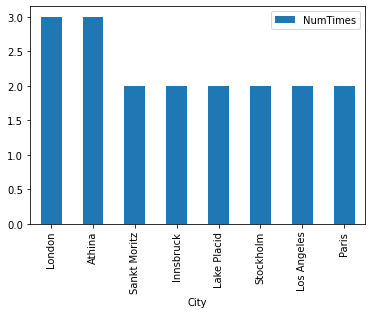

In [19]:
cities_df = cities.DataFrame()
cities_df.plot.bar(x='City', y='NumTimes')

In [20]:
#collapse_output
%%sql 
CREATE OR ALTER VIEW city_year AS
SELECT DISTINCT City,
                Year
FROM            athlete_events

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


ResourceClosedError: This result object does not return rows. It has been closed automatically.

In [21]:
%%sql
SELECT City,
       Count(Year) AS NumTimes
FROM   city_year
GROUP  BY City
HAVING Count(Year) > 1
ORDER  BY numtimes DESC 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


City,NumTimes
London,3
Athina,3
Sankt Moritz,2
Innsbruck,2
Lake Placid,2
Stockholm,2
Los Angeles,2
Paris,2


#### Find the seasons for each year as two columns (Summer, Winter)

In [22]:
%%sql
SELECT *
FROM   (SELECT DISTINCT PARSENAME(REPLACE(Games, ' ', '.'), 2) AS Year,
                        PARSENAME(REPLACE(Games, ' ', '.'), 1) AS Season
        FROM   athlete_events) t1
       PIVOT ( Count(Season)
             FOR Season IN (Summer,
                            Winter) ) piv
ORDER  BY Year 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


Year,Summer,Winter
1896,1,0
1900,1,0
1904,1,0
1906,1,0
1908,1,0
1912,1,0
1920,1,0
1924,1,1
1928,1,1
1932,1,1


#### What is the average age of participants?

In [23]:
%%sql
SELECT Avg(Cast(Age AS INT)) as AvgAge
FROM   athlete_events
WHERE  age IS NOT NULL
       AND age <> 'NA' 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


AvgAge
25


#### What is the average age per season?

In [24]:
%%sql
SELECT Season,
       Avg(CAST(Age AS INT)) AvgAge
FROM   athlete_events
WHERE  Age <> 'NA'
GROUP  BY Season 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


Season,AvgAge
Summer,25
Winter,25


#### Is the average age fixed across the seasons and years?

In [25]:
%%sql result <<
SELECT Year, 
       Season, 
       AVG(cast(Age as int)) AverageAge 
FROM   athlete_events
WHERE Age is not NULL 
      AND Age <> 'NA'
GROUP BY Year, 
         Season
ORDER BY Year, 
         Season

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
Returning data to local variable result


In [26]:
result_df = result.DataFrame()
summer_df = result_df[result_df['Season'] == 'Summer']
winter_df = result_df[result_df['Season'] == 'Winter']

<AxesSubplot:title={'center':'Winter Participants Average Age'}, xlabel='Year', ylabel='AverageAge'>

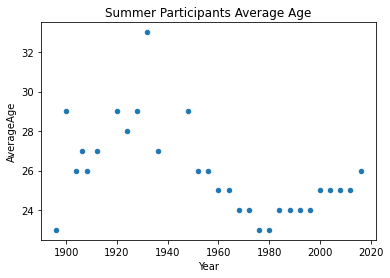

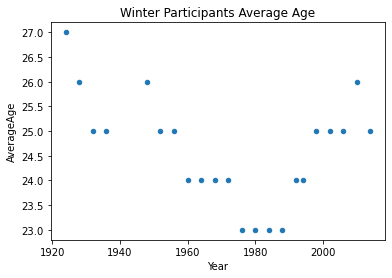

In [27]:
summer_df.plot.scatter(x='Year',y='AverageAge', title='Summer Participants Average Age')
winter_df.plot.scatter(x='Year',y='AverageAge', title='Winter Participants Average Age')

The average for summer Olympics in 1932 looks too high, is this a valid result? if yes why did it happen?

In [28]:
%%sql
select AVG(cast(Age as int)) as AvgAge from athlete_events
left join noc_regions on athlete_events.NOC = noc_regions.NOC
where Year=1932 and Age <> 'NA' and Season='Summer'

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


AvgAge
33


So, the average age was high, why is that the case?
Let's look at a more statistics about the games broken down by year and season.

In [29]:
%%sql
SELECT year,
       Min(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerMinAge,
       Max(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerMaxAge,
       Avg(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerAvgAge,
       Var(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerVarAge,
       Min(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterMinAge,
       Max(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterMaxAge,
       Avg(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterAvgAge,
       Var(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterVarAge
FROM   athlete_events
WHERE  age IS NOT NULL
       AND age <> 'NA'
GROUP  BY year
ORDER  BY year 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


year,SummerMinAge,SummerMaxAge,SummerAvgAge,SummerVarAge,WinterMinAge,WinterMaxAge,WinterAvgAge,WinterVarAge
1896,10,40,23,22.02240143369178,None,None,None,None
1900,13,71,29,87.57875351516955,None,None,None,None
1904,14,71,26,76.6066534940619,None,None,None,None
1906,13,54,27,62.617258530706444,None,None,None,None
1908,14,61,26,61.15578403594632,None,None,None,None
1912,13,67,27,64.84038295212197,None,None,None,None
1920,13,72,29,68.44374620002326,None,None,None,None
1924,13,81,28,74.08304035936791,11,58,27,48.97374171326985
1928,11,97,29,118.93684427853675,15,54,26,37.10742966900141
1932,13,96,33,202.85578680390805,11,52,25,33.449755356216194


It is clear that there's a high variability in participants ages in 1932. Let's have a closer look at the data to find out what could the reason behind that be. 

In which sport did older participants take part in?

In [30]:
%%sql
select top 10 * from athlete_events
where year = '1932' and season = 'Summer' and age <> 'NA' and age = 96

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
49663,Winslow Homer,M,96,NA,NA,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NA


Oh, the older folks participated in Art Competitions.
Let's see what impact does removing `Art Competitions` have on the age distribution.

In [31]:
%%sql
SELECT year,
       Min(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerMinAge,
       Max(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerMaxAge,
       Avg(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerAvgAge,
       Var(CASE
             WHEN season = 'Summer' THEN Cast(age AS INT)
           END) SummerVarAge,
       Min(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterMinAge,
       Max(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterMaxAge,
       Avg(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterAvgAge,
       Var(CASE
             WHEN season = 'Winter' THEN Cast(age AS INT)
           END) WinterVarAge
FROM   athlete_events
WHERE  age IS NOT NULL
       AND age <> 'NA'
       AND Sport <> 'Art Competitions'
GROUP  BY year
ORDER  BY year 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


year,SummerMinAge,SummerMaxAge,SummerAvgAge,SummerVarAge,WinterMinAge,WinterMaxAge,WinterAvgAge,WinterVarAge
1896,10,40,23,22.02240143369178,None,None,None,None
1900,13,71,29,87.57875351516955,None,None,None,None
1904,14,71,26,76.6066534940619,None,None,None,None
1906,13,54,27,62.617258530706444,None,None,None,None
1908,14,61,26,61.15578403594632,None,None,None,None
1912,13,64,27,62.604400100967034,None,None,None,None
1920,13,72,29,67.98906348229981,None,None,None,None
1924,13,60,27,54.157015903460966,11,58,27,48.97374171326985
1928,11,63,25,47.05709575019104,15,54,26,37.10742966900141
1932,13,54,25,38.055043191309956,11,52,25,33.449755356216194


I am statisfied with this now, it seems to match the result reported in [here](https://www.washingtonpost.com/sports/olympics/2021/07/31/oldest-youngest-olympians/).

#### What is trend of age in each season? 
This is a fun question, let's try to find the slope of the best fit line across the previous plots. This can be achieved by implementing the equation of the slope of single variable linear regression:
$$b= \frac{n\sum{xy} - \sum{x}\sum{y}}{n\sum{x^2}-(\sum{x})^2}$$

In [32]:
%%sql
select (n*SigmaXY - SigmaX * SigmaY)/(n*SigmaX2 - SigmaX^2) as b from (
                select cast(Sum(Y) as float) as SigmaY, 
                       sum(X^2) as SigmaX2,
                       sum(X) as SigmaX,
                       sum(Y*X) as SigmaXY,
                       count(*) as n
                       from (
                        SELECT Year-1896 as X, 
                               AVG(cast(Age as int)) as Y 
                        FROM   athlete_events
                        WHERE Age is not NULL 
                              AND Age <> 'NA'
                              AND Sport <> 'Art Competitions'
                              AND Season = 'Summer'
                        GROUP BY Year 
                ) t1 
) t2

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


b
-0.4668425612349374


In [33]:
%%sql
SELECT ( n * sigmaxy - sigmax * sigmay ) / ( n * sigmax2 - sigmax^2 ) AS b
FROM   (SELECT Cast(Sum(y) AS FLOAT) AS SigmaY,
               Sum(x^2)              AS SigmaX2,
               Sum(x)                AS SigmaX,
               Sum(y * x)            AS SigmaXY,
               Count(*)              AS n
        FROM   (SELECT year - 1896           AS X,
                       Avg(Cast(age AS INT)) AS Y
                FROM   athlete_events
                WHERE  age IS NOT NULL
                       AND age <> 'NA'
                       AND sport <> 'Art Competitions'
                       AND season = 'Winter'
                GROUP  BY year) t1) t2 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


b
-0.13860606401530068


We can see a stronger negative trend in summer events than in winter events.

#### What is the number of participating nations for each year and season?

In [34]:
%%sql result <<
SELECT *
FROM   (SELECT DISTINCT Year,
                        Season,
                        region
        FROM   athlete_events
               LEFT JOIN noc_regions
                      ON athlete_events.NOC = noc_regions.NOC) t
       PIVOT ( Count(region)
             FOR season IN (Summer,
                            Winter) ) piv
ORDER  BY Year 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
Returning data to local variable result


<AxesSubplot:title={'center':'# Participating Nations The Olympics'}, xlabel='Year'>

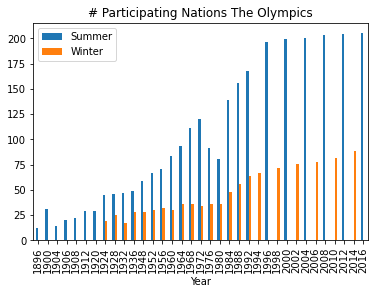

In [35]:
result_df = result.DataFrame()
result_df.plot.bar(x='Year', y =['Summer', 'Winter'], title='# Participating Nations The Olympics')

Few observation:
* The number of participating nations has been increasing since the inception of the first Olympic season in 1896.
* The first winter Olympics was held in 1924. 
* Less nations participate in the winter Olympics as compared with the summer ones. 
* Since 1992, the Olympics are held every two years for alternating seasons.

####  In which years and seasons did Iraq not participate in the Olympics?

In [36]:
%%sql
SELECT Year,
       Season,
       Sum(Iraq) AS IraqIn
FROM   (SELECT DISTINCT Year,
                        Season,
                        region,
                        CASE region
                          WHEN 'Iraq' THEN 1
                          ELSE 0
                        END AS Iraq
        FROM   athlete_events
               LEFT JOIN noc_regions
                      ON athlete_events.NOC = noc_regions.NOC) t
GROUP  BY Year,
          Season
HAVING Sum(Iraq) = 0
ORDER  BY Year 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


Year,Season,IraqIn
1896,Summer,0
1900,Summer,0
1904,Summer,0
1906,Summer,0
1908,Summer,0
1912,Summer,0
1920,Summer,0
1924,Winter,0
1924,Summer,0
1928,Winter,0


#### What is the number of medals per Sport for sports which have more than 500 medals granted?

In [37]:
%%sql results <<
SELECT Sport,
       COUNT(Medal) AS MedalsGranted
FROM   (SELECT DISTINCT CAST(athlete_events.NAME AS CHAR(100)) AS Name,
                        Games,
                        region,
                        Sport,
                        Medal
        FROM   athlete_events
               LEFT JOIN noc_regions
                      ON athlete_events.NOC = noc_regions.NOC
        WHERE  Medal IS NOT NULL
               AND Medal <> 'NA') t1
GROUP  BY Sport
HAVING COUNT(Medal) > 500
ORDER  BY MedalsGranted DESC

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
Returning data to local variable results


<AxesSubplot:xlabel='Sport'>

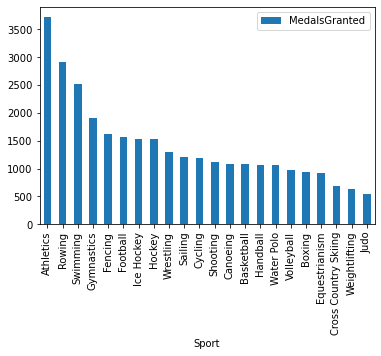

In [38]:
results_df = results.DataFrame()
results_df.plot.bar(x='Sport', y='MedalsGranted')

#### Which countries participated less than 5 times in the Olympics?

In [39]:
%%sql
SELECT region,
       Count(Games) AS TimesParticipated
FROM   (SELECT DISTINCT Games,
                        region
        FROM   athlete_events
               LEFT JOIN noc_regions
                      ON athlete_events.NOC = noc_regions.NOC
        WHERE  region IS NOT NULL
               AND region <> 'NA') t1
GROUP  BY region
HAVING Count(Games) < 5
ORDER  BY TimesParticipated 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


region,TimesParticipated
Kosovo,1
South Sudan,1
Marshall Islands,3
Kiribati,4


#### Which are the top 5 countries by the number of Judo players?

In [40]:
%%sql
SELECT TOP 5 region,
       Count(DISTINCT Cast(Name AS NVARCHAR(50))) NumPlayers
FROM   athlete_events
       LEFT JOIN noc_regions
              ON athlete_events.NOC = noc_regions.NOC
WHERE  Sport = 'Judo'
GROUP  BY region
ORDER  BY NumPlayers DESC 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


region,NumPlayers
Germany,95
South Korea,95
Russia,94
France,93
Japan,93


#### What is percentage of Judo players in each of these countries?

In [41]:
%%sql result <<
SELECT top 20 region,
       ( CAST(COUNT(DISTINCT CAST(Name AS NVARCHAR(50))) AS FLOAT) /
           (SELECT COUNT(DISTINCT CAST(Name AS NVARCHAR(50))) NumJudoPlayers
        FROM
           athlete_events
        WHERE
           sport =
           'Judo'
           ) ) * 100 JudoPlayersPercentage
FROM   athlete_events
       LEFT JOIN noc_regions
              ON athlete_events.noc = noc_regions.noc
WHERE  sport = 'Judo'
GROUP  BY region
ORDER  BY JudoPlayersPercentage DESC 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.
Returning data to local variable result


<AxesSubplot:xlabel='region'>

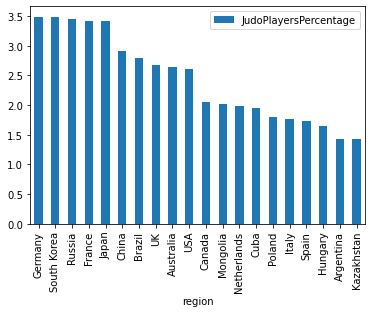

In [42]:
result_df = result.DataFrame()
result_df.plot.bar(x='region', y='JudoPlayersPercentage')

#### Which are the top 5 countries by the number of medals in judo?

In [43]:
%%sql
SELECT TOP 5 region,
             Count(Medal) AS NumMedals
FROM   (SELECT DISTINCT CAST(NAME AS CHAR(100)) AS Name,
                        Games,
                        region,
                        Medal
        FROM   athlete_events
               LEFT JOIN noc_regions
                      ON athlete_events.NOC = noc_regions.NOC
        WHERE  sport = 'Judo'
               AND Medal <> 'NA') t1
GROUP  BY region
ORDER  BY NumMedals DESC 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


region,NumMedals
Japan,84
France,49
Russia,43
South Korea,43
Germany,37


#### Who are the top 5 players who participated the largest number of times?

In [44]:
%%sql
SELECT TOP 5 CAST(NAME AS CHAR(100)) Name,
             COUNT(Games)            GamesParticipated
FROM   athlete_events
WHERE Sport <> 'Art Competitions'
GROUP  BY CAST(NAME AS CHAR(100))
ORDER  BY GamesParticipated DESC 

 * mssql+pyodbc://@localhost\SQLEXPRESS/OlympicsHistory?driver=SQL+Server&trusted_connection=yes
Done.


Name,GamesParticipated
Heikki Ilmari Savolainen,39
"Joseph ""Josy"" Stoffel",38
Ioannis Theofilakis,36
Takashi Ono,33
Andreas Wecker,32


# Conclusions

Writing this article was really interesting, and I enjoyed learning about the Olympics things that I didn't know. This article is far from being perfect but I feel, it serves its purpose. 

Writing SQL statements like this has its benefits as well as its limitations. 

Some of the positives include: 
* The ability to grab the needed data and plot it in Python or apply and subsequent processing to it is very interesting.

Among the limitations are:
* If the query returns a large table, Jupyter could freeze and crash. To alleviate this issue, one can limit the size of returned rows by using `select top x`, for example. 
* Syntax highlighting, code auto completion, code formatting/linting are missing. 
